# Exploratory data analysis of the data from Meningioma patients

---

In this notebook we will analyze PBMC data set from patient 11 obtained from blood samples taken at 3 different time points before, during and after the proton therapy treatment. The treatment takes approximately 6 weeks with multiple sessions.

---

## 0. Environmental setup

In [6]:
import random
import numpy as np
import pandas as pd
import sys
import os

from statannot import add_stat_annotation

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

sys.path.append("../../../../../")
from src.utils.notebooks.eda import *
from collections import Counter

seed = 1234
random.seed(seed)
np.random.seed(seed)

%reload_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 1. Read in data

Next, we read in the data sets that describe the PBMC population of the healthy controls as well as of patient 11 at the different time points over the course of the treatment.

In [7]:
hv_root_data_dir = "../../../../../data/control/marker"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"
marker_label_file_path = "/preprocessed/full_pipeline/marker_labels/marker_labels.csv"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
hv_data = read_in_marker_dataset(
    data_dir=hv_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
hv_data["id"] = hv_data["sample"] + hv_data["timepoint"]

Load data: 100%|██████████| 8/8 [00:00<00:00, 36.22it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
meningioma_patients = ["p33", "p38", "p48"]

tp1_root_data_dir = "../../../../../data/meningioma/marker/timepoint_1/"
tp2_root_data_dir = "../../../../../data/meningioma/marker/timepoint_2/"
tp3_root_data_dir = "../../../../../data/meningioma/marker/timepoint_3/"
tp4_root_data_dir = "../../../../../data/meningioma/marker/timepoint_4/"

tp1_features = read_in_marker_dataset(
    data_dir=tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    filter_samples=meningioma_patients,
    marker_label_file_path=marker_label_file_path,
)

tp2_features = read_in_marker_dataset(
    data_dir=tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    filter_samples=meningioma_patients,
    marker_label_file_path=marker_label_file_path,
)

tp3_features = read_in_marker_dataset(
    data_dir=tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    filter_samples=meningioma_patients,
    marker_label_file_path=marker_label_file_path,
)

meningioma_data = tp1_features.append(tp2_features).append(tp3_features)
meningioma_data["id"] = meningioma_data["sample"] + meningioma_data["timepoint"]

FileNotFoundError: [Errno 2] No such file or directory: '../../../../../data/meningioma/patients/marker/timepoint_1/'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
counts = Counter(meningioma_data.loc[:, "id"])
{k: counts[k] for k in sorted(list(counts.keys()))}

{'p271': 507,
 'p272': 576,
 'p273': 580,
 'p331': 517,
 'p332': 501,
 'p333': 595,
 'p371': 540,
 'p372': 438,
 'p373': 594,
 'p381': 481,
 'p382': 539,
 'p383': 533,
 'p421': 446,
 'p422': 451,
 'p423': 546}

<IPython.core.display.Javascript object>

We will randomly subsample the data from each condition to the same sample size that is the minimum number of samples in any of the conditions.

In [6]:
np.random.seed(seed)
n_samples = np.min([len(hv_data)] + list(Counter(meningioma_data.id).values()))

hv_data = hv_data.iloc[
    np.random.choice(
        list(range(len(hv_data))),
        replace=False,
        size=n_samples * len(np.unique(meningioma_data.loc[:, "sample"])),
    )
]

<IPython.core.display.Javascript object>

In [7]:
sampler = RandomUnderSampler(random_state=seed)
idc = np.array(list(range(len(meningioma_data)))).reshape(-1, 1)
sample_idc, _ = sampler.fit_resample(idc, np.array(meningioma_data.loc[:, "id"]))
meningioma_data = meningioma_data.iloc[sample_idc[:, 0]]

<IPython.core.display.Javascript object>

In [8]:
data = hv_data.append(meningioma_data)

<IPython.core.display.Javascript object>

In [9]:
data["cd4_cd8"] = np.repeat("cd8+", len(data))
data.loc[(data["cd8"] == 0) & (data["cd4"] == 1), "cd4_cd8"] = "cd4+"
data.loc[(data["cd8"] == 1) & (data["cd4"] == 1), "cd4_cd8"] = "cd4+cd8+"
data.loc[(data["cd8"] == 0) & (data["cd4"] == 0), "cd4_cd8"] = "cd4-cd8-"
data.head()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,max_cd16_3d_int,mean_cd16_3d_int,std_cd16_3d_int,q25_cd16_3d_int,q75_cd16_3d_int,median_cd16_3d_int,kurtosis_cd16_3d_int,skewness_cd16_3d_int,cd16,cd4_cd8
HV1_PBMCs_Dapi_CD8_CD4_28_07_21_2X_16bit_2X_30_1,2,64.0,76.0,0.842105,28.701431,39.775945,33.466759,33.531659,28.701431,31.765103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cd4+
HV5_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_11_7,8,54.0,73.0,0.739726,21.729859,36.770468,31.634963,30.819654,21.729859,27.758344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cd4-cd8-
HV5_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_25_3,4,63.0,70.0,0.900000,27.586776,35.033384,32.370909,32.397846,27.586776,31.409956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cd8+
HV5_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_7_5,6,61.0,67.0,0.910448,27.664185,33.599032,31.217439,31.174702,27.664185,30.488326,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cd4+
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_27_6,7,68.0,80.0,0.850000,29.271972,41.982396,34.141965,34.792148,29.271972,32.603569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cd4-cd8-


<IPython.core.display.Javascript object>

---

## 2. Dimensionality reduction

Next, we will clean the data and remove samples with missing values, constant features as well as those samples that were flagged for not passing our quality checks.

In [10]:
data = preprocess_data(data)
sample_labels = data.loc[:, "sample"]
condition_labels = data.loc[:, "timepoint"]
cd4_cd8_label = data.loc[:, "cd4_cd8"]

Nuclei that did not pass the quality check: 425/8760. Remaining: 8335.
Removed 38 constant or features with missing values. Remaining: 265.
Removed additional 6 features. Remaining: 259.


<IPython.core.display.Javascript object>

In [11]:
features = data._get_numeric_data().iloc[:, :-1]
nmco_features = features.copy()
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("cd8")]
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("cd4")]
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("cd16")]
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("dna_3d_int")]
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("dna_2d_int")]
nmco_features.head()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,d75_radius,...,nuclear_mean_int,nuclear_std_int,rdp_1,rdp_2,rdp_3,rdp_4,rdp_5,rdp_6,rdp_7,rdp_8
HV1_PBMCs_Dapi_CD8_CD4_28_07_21_2X_16bit_2X_30_1,64.0,76.0,0.842105,28.701431,39.775945,33.466759,33.531659,28.701431,31.765103,35.265063,...,29662.849420,9408.380695,0.003748,0.019116,0.046103,0.108000,0.201558,0.326777,0.534139,0.758546
HV5_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_11_7,54.0,73.0,0.739726,21.729859,36.770468,31.634963,30.819654,21.729859,27.758344,34.272672,...,26344.156256,8451.819450,0.000143,0.010405,0.030785,0.093613,0.188579,0.315683,0.530175,0.758281
HV5_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_25_3,63.0,70.0,0.900000,27.586776,35.033384,32.370909,32.397846,27.586776,31.409956,33.582889,...,22586.292518,7058.351766,0.006344,0.025390,0.057138,0.131067,0.236766,0.374235,0.579572,0.788160
HV5_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_7_5,61.0,67.0,0.910448,27.664185,33.599032,31.217439,31.174702,27.664185,30.488326,31.983382,...,21685.129834,6940.769463,0.007278,0.027349,0.060213,0.134911,0.238410,0.370713,0.576616,0.786378
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_27_6,68.0,80.0,0.850000,29.271972,41.982396,34.141965,34.792148,29.271972,32.603569,36.450994,...,18245.913928,6640.811662,0.005981,0.026870,0.062668,0.138904,0.238186,0.360513,0.554331,0.767493


<IPython.core.display.Javascript object>

Finally, we will reduce the dimensionality of the data set further by removing highly correlated features ($\rho > 0.8$).

In [12]:
nmco_features = features = remove_correlated_features(nmco_features, threshold=0.8)

Removed 150/205 features with a Pearson correlation above 0.8. Remaining: 55


<IPython.core.display.Javascript object>

There are 55 features that remain which have correlation of less than 0.8 to any other features.

---

## 3. Data visualization

Next, we will visualize the data set using TSNE. To this end, we will first z-score the data.

In [13]:
nmco_features_sc = pd.DataFrame(
    StandardScaler().fit_transform(nmco_features),
    index=nmco_features.index,
    columns=nmco_features.columns,
)
nmco_features_sc.describe()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,med_radius,concavity,area_bbarea,avg_curvature,std_curvature,npolarity_changes,...,weighted_moments_hu-2,moments_normalized-0-2,moments_normalized-2-0,moments_normalized-2-3,moments_central-0-1,moments_central-1-0,equivalent_diameter.1,extent,rel_hc_volume,rdp_1
count,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,...,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03,8.335000e+03
mean,-4.023709e-16,6.137862e-16,1.278721e-16,-6.734598e-16,1.892507e-16,2.233500e-16,3.853213e-16,1.541285e-15,-6.052614e-16,1.875458e-17,...,-5.328005e-18,3.469597e-16,3.949117e-16,-9.630369e-18,-1.204129e-17,-7.246087e-18,4.893240e-16,-1.960706e-16,3.247952e-16,-1.289377e-17
std,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,...,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00,1.000060e+00
min,-6.119498e+00,-3.436383e+00,-6.269929e+00,-5.745802e+00,-8.027082e+00,-1.270720e+00,-1.086512e+01,-1.328416e+01,-2.508503e+00,-2.629376e+00,...,-6.671738e-02,-2.854539e+00,-2.926390e+00,-4.286783e+01,-5.116082e+00,-5.043502e+00,-1.202915e+01,-8.058147e+00,-1.714993e+01,-9.361934e-01
25%,-6.316490e-01,-6.262253e-01,-5.810036e-01,-5.001139e-01,-6.567364e-01,-5.835527e-01,-5.377627e-01,-5.106879e-01,-7.071650e-01,-6.432193e-01,...,-5.994683e-02,-6.157105e-01,-6.299309e-01,-3.752504e-01,-5.770169e-01,-7.305147e-01,-5.260491e-01,-5.441286e-01,-5.013868e-01,-7.609268e-01
50%,7.646054e-02,-2.047016e-01,1.242022e-01,1.311474e-01,-6.255677e-02,-2.623142e-01,1.317541e-01,8.783924e-02,-1.205234e-01,-4.737228e-02,...,-4.687898e-02,-1.101179e-01,-1.267764e-01,1.380671e-02,-9.920399e-04,-5.782998e-03,-5.070691e-02,1.171768e-01,1.428235e-01,-3.164359e-01
75%,6.075427e-01,3.573301e-01,7.519089e-01,6.833735e-01,5.823354e-01,2.684110e-01,6.591246e-01,6.221138e-01,5.945785e-01,5.484747e-01,...,-1.466157e-02,4.724109e-01,4.697298e-01,3.881627e-01,5.870280e-01,6.965631e-01,5.100315e-01,6.825712e-01,6.408651e-01,4.267735e-01
max,3.617008e+00,1.328406e+01,2.141946e+00,2.562135e+00,9.288117e+00,2.506604e+01,2.814632e+00,6.702579e+00,1.107530e+01,1.117441e+01,...,8.923289e+01,2.343474e+01,9.753519e+00,9.681596e+00,6.041207e+00,4.383728e+00,5.051443e+00,2.972134e+00,4.341829e+00,7.509660e+00


<IPython.core.display.Javascript object>

Next, we compute the TSNE.

In [14]:
tsne = TSNE(random_state=seed)
tsne_embs = tsne.fit_transform(nmco_features_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=nmco_features_sc.index
)
tsne_embs.loc[:, "sample"] = np.array(data.loc[tsne_embs.index, "sample"])
tsne_embs.loc[:, "timepoint"] = np.array(data.loc[tsne_embs.index, "timepoint"])

<IPython.core.display.Javascript object>

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


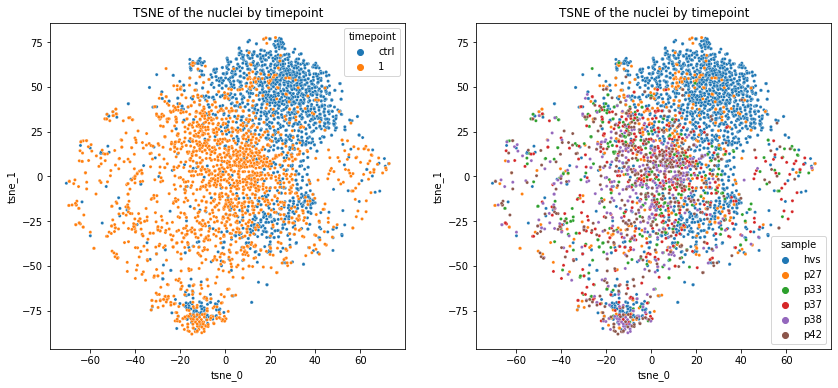

<IPython.core.display.Javascript object>

In [15]:
tmp_embs = tsne_embs.loc[tsne_embs.loc[:, "timepoint"].isin(["ctrl", "1"])]
fig, ax = plt.subplots(figsize=[14, 6], ncols=2)
ax = ax.flatten()
ax[0] = sns.scatterplot(
    data=tmp_embs, x="tsne_0", y="tsne_1", hue="timepoint", ax=ax[0], s=10
)
ax[0].set_title("TSNE of the nuclei by timepoint")
tmp_embs.loc[(tmp_embs["timepoint"] == "ctrl"), "sample"] = "hvs"
ax[1] = sns.scatterplot(
    data=tmp_embs, x="tsne_0", y="tsne_1", hue="sample", ax=ax[1], s=10
)
ax[1].set_title("TSNE of the nuclei by timepoint")
plt.show()

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


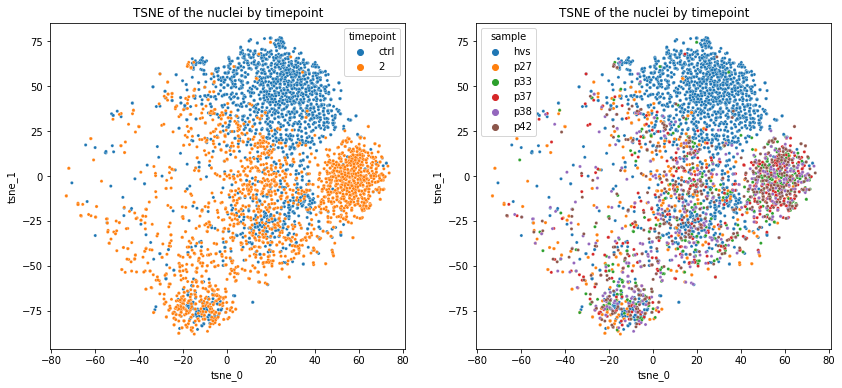

<IPython.core.display.Javascript object>

In [16]:
tmp_embs = tsne_embs.loc[tsne_embs.loc[:, "timepoint"].isin(["ctrl", "2"])]
fig, ax = plt.subplots(figsize=[14, 6], ncols=2)
ax = ax.flatten()
ax[0] = sns.scatterplot(
    data=tmp_embs, x="tsne_0", y="tsne_1", hue="timepoint", ax=ax[0], s=10
)
ax[0].set_title("TSNE of the nuclei by timepoint")
tmp_embs.loc[(tmp_embs.loc[:, "timepoint"] == "ctrl"), "sample"] = "hvs"
ax[1] = sns.scatterplot(
    data=tmp_embs, x="tsne_0", y="tsne_1", hue="sample", ax=ax[1], s=10
)
ax[1].set_title("TSNE of the nuclei by timepoint")
plt.show()

/home/paysan_d/miniconda3/envs/icp/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


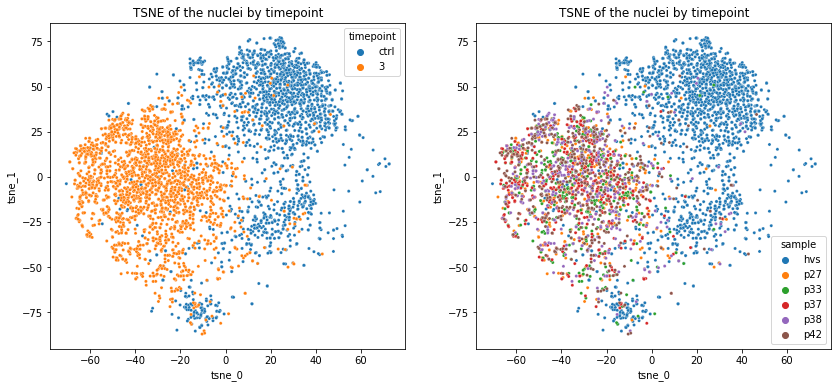

<IPython.core.display.Javascript object>

In [17]:
tmp_embs = tsne_embs.loc[tsne_embs.loc[:, "timepoint"].isin(["ctrl", "3"])]
fig, ax = plt.subplots(figsize=[14, 6], ncols=2)
ax = ax.flatten()
ax[0] = sns.scatterplot(
    data=tmp_embs, x="tsne_0", y="tsne_1", hue="timepoint", ax=ax[0], s=10
)
ax[0].set_title("TSNE of the nuclei by timepoint")
tmp_embs.loc[(tmp_embs.loc[:, "timepoint"] == "ctrl"), "sample"] = "hvs"
ax[1] = sns.scatterplot(
    data=tmp_embs, x="tsne_0", y="tsne_1", hue="sample", ax=ax[1], s=10
)
ax[1].set_title("TSNE of the nuclei by timepoint")
plt.show()

---

## Separability of the time points

In [39]:
np.unique(cd4_cd8_label)

array(['cd4+', 'cd4+cd8+', 'cd4-cd8-', 'cd8+'], dtype=object)

<IPython.core.display.Javascript object>

In [60]:
rfc = RandomForestClassifier(
    n_estimators=100, n_jobs=10, random_state=seed, class_weight="balanced"
)
avg_conf_mtx = compute_avg_conf_mtx(
    model=rfc, n_folds=5, features=nmco_features_sc, labels=cd4_cd8_label
)

<IPython.core.display.Javascript object>

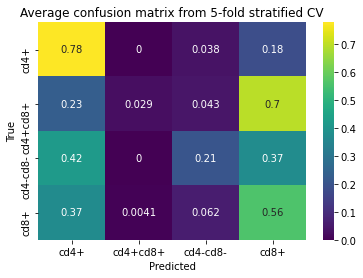

<IPython.core.display.Javascript object>

In [61]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.heatmap(avg_conf_mtx, annot=True, cmap="viridis", ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.title("Average confusion matrix from {}-fold stratified CV".format(5))
plt.show()

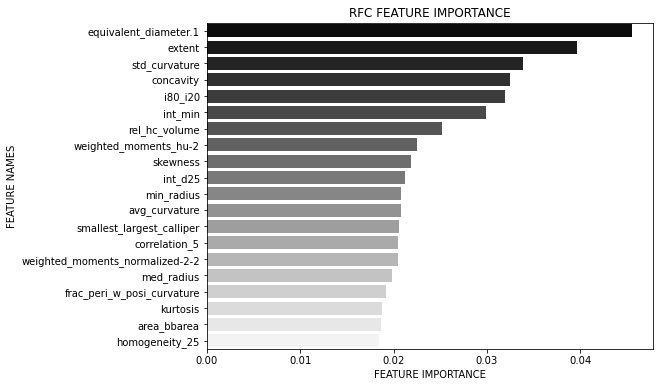

<IPython.core.display.Javascript object>

In [63]:
rfc = rfc.fit(
    nmco_features_sc,
    cd4_cd8_label,
)
plot_feature_importance(
    rfc.feature_importances_,
    nmco_features_sc.columns,
    "RFC ",
)

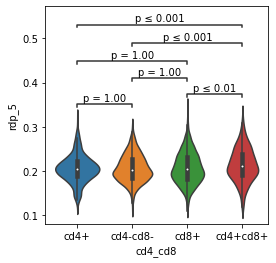

<IPython.core.display.Javascript object>

In [70]:
fig, ax = plt.subplots(figsize=[4, 4])
sns.violinplot(
    data=data,
    x="cd4_cd8",
    y="rdp_5",
    ax=ax,
)
add_stat_annotation(
    ax,
    data=data,
    x="cd4_cd8",
    y="rdp_5",
    box_pairs=[
        ("cd4+", "cd8+"),
        ("cd4+", "cd4+cd8+"),
        ("cd4+", "cd4-cd8-"),
        ("cd8+", "cd4+cd8+"),
        ("cd8+", "cd4-cd8-"),
        ("cd4+cd8+", "cd4-cd8-"),
    ],
    test="Mann-Whitney",
    loc="inside",
    verbose=0,
    text_format="simple",
    comparisons_correction="bonferroni",
)
plt.show()

Let us also test the separability between individual samples

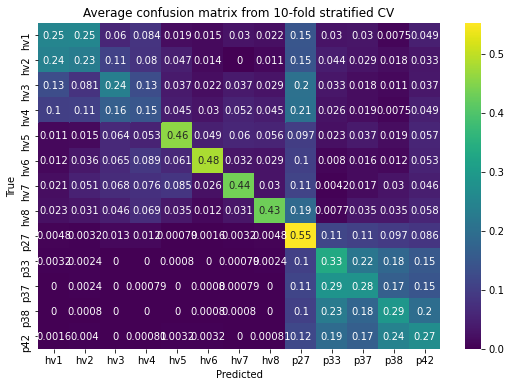

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [113]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=10, random_state=seed)
avg_conf_mtx = compute_avg_conf_mtx(
    model=rfc, n_folds=10, features=nmco_features_sc, labels=sample_labels
)
fig, ax = plt.subplots(figsize=[9, 6])
ax = sns.heatmap(avg_conf_mtx, annot=True, cmap="viridis", ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.title("Average confusion matrix from {}-fold stratified CV".format(10))
plt.show()

---

## Cell type abundances

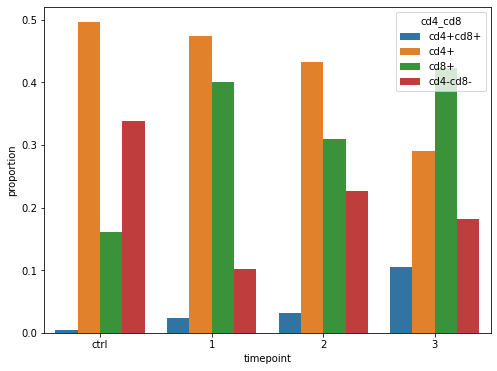

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [106]:
fig, ax = plt.subplots(figsize=[8, 6])
x, y, hue = "timepoint", "proportion", "cd4_cd8"
hue_order = ["cd4+cd8+", "cd4+", "cd8+", "cd4-cd8-"]

l = (
    data[x]
    .sort_values(ascending=True)
    .groupby(data[hue])
    .value_counts()
    .rename(y)
    .reset_index()
)
for cond in np.unique(l["timepoint"]):
    l.loc[l["timepoint"] == cond, "proportion"] /= np.sum(
        l.loc[l["timepoint"] == cond, "proportion"]
    )
l.pipe(
    (sns.barplot, "data"),
    x=x,
    y=y,
    hue=hue,
    order=["ctrl", "1", "2", "3"],
    hue_order=hue_order,
    ax=ax,
)
plt.show()

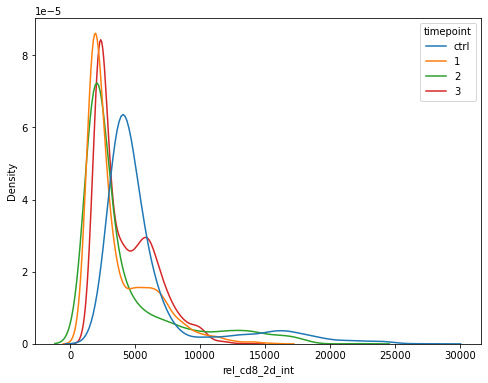

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [107]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.kdeplot(data=data, x="rel_cd8_2d_int", hue="timepoint", ax=ax)
plt.show()

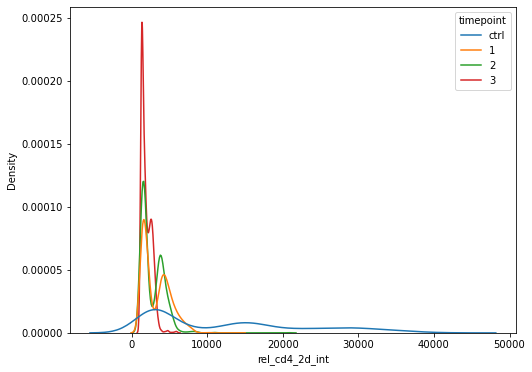

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [108]:
fig, ax = plt.subplots(figsize=[8, 6])
ax = sns.kdeplot(data=data, x="rel_cd4_2d_int", hue="timepoint", ax=ax)
plt.show()